### Import packages 

In [2]:
import pandas as pd 
import csv
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

### Load data 

In [11]:
# Read the file and skip the first row, which contains "LinearAcceleration" title
df = pd.read_csv('/Users/thomasjohnson/Desktop/Sports Tech/CM2024 - Project course/JumpPro/Jonatan Chest/Acc-2025_04_04-11_32_45.csv', skiprows=1)

# Generate time column using the sample rate (50 Hz)
sample_rate = 50  # Hz
df = df.reset_index(drop=True)
df['time'] = df.index / sample_rate  # time in seconds

# Return first few rows, total time, and number of samples
df.head(), df['time'].iloc[-1], len(df)

(        Timestamp      AccX      AccY      AccZ  time
 0  1743758128.013 -9.475916  2.962420  0.875804  0.00
 1  1743758128.013 -9.499846  3.005492  0.990664  0.02
 2  1743758128.013 -9.413700  3.034207  1.028950  0.04
 3  1743758128.013 -9.475916  2.981564  1.033736  0.06
 4  1743758128.092 -9.423272  2.962420  1.052880  0.08,
 np.float64(1034.54),
 51728)

In [12]:
# # convert type of row 1 in 'Timestamp' to numeric and create a new 'time' column in seconds
# df['Timestamp'] = pd.to_numeric(df['Timestamp'], errors='coerce')
# df['time'] = ((df['Timestamp'] - df['Timestamp'].iloc[0]) / 1e9).astype(float) # convert to seconds 


# # Return first few rows, total time, and number of samples
# df.head(), df['time'].iloc[-1], len(df)


In [13]:
print(df['time'].min(), df['time'].max())


0.0 1034.54


In [14]:
print(df['Timestamp'].head(10))
print(df['Timestamp'].unique())

0    1743758128.013
1    1743758128.013
2    1743758128.013
3    1743758128.013
4    1743758128.092
5    1743758128.092
6    1743758128.092
7    1743758128.092
8     1743758128.17
9     1743758128.17
Name: Timestamp, dtype: object
['1743758128.013' '1743758128.092' '1743758128.17' ...
 'Relative Timestamp at start : 757107059 ms'
 'UTC Timestamp at synchronisation : 1743759167667 ms'
 'Relative Timestamp at synchronisation : 758152266 ms']


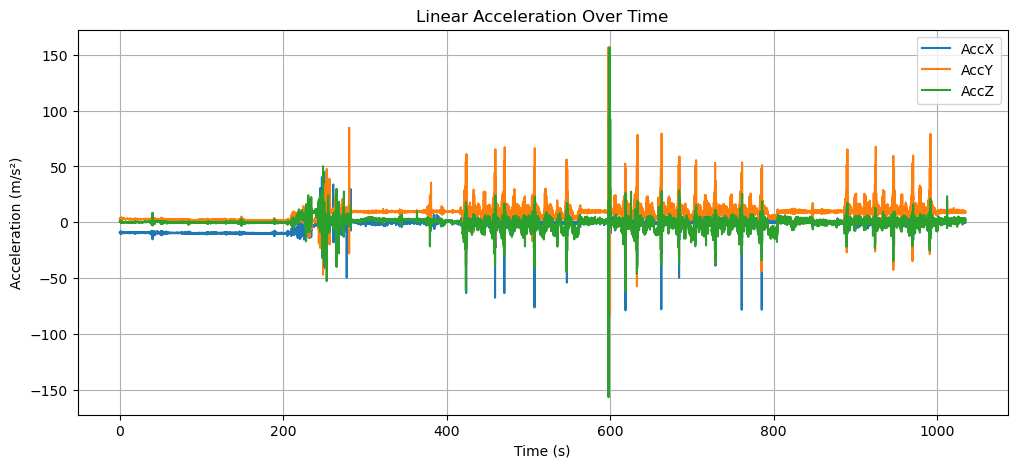

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['AccX'], label='AccX')
plt.plot(df['time'], df['AccY'], label='AccY')
plt.plot(df['time'], df['AccZ'], label='AccZ')
plt.title('Linear Acceleration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()


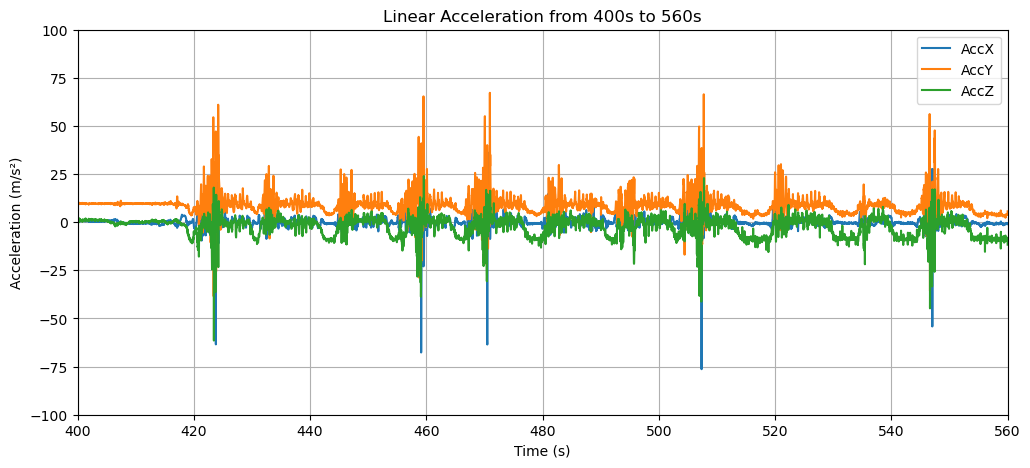

In [16]:
#Plot from 400s to 560s
plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['AccX'], label='AccX')
plt.plot(df['time'], df['AccY'], label='AccY')
plt.plot(df['time'], df['AccZ'], label='AccZ')
plt.xlim(400, 560)  # Adjust x-axis limits to zoom in
plt.ylim(-100, 100)  # Adjust y-axis limits if needed
plt.title('Linear Acceleration from 400s to 560s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

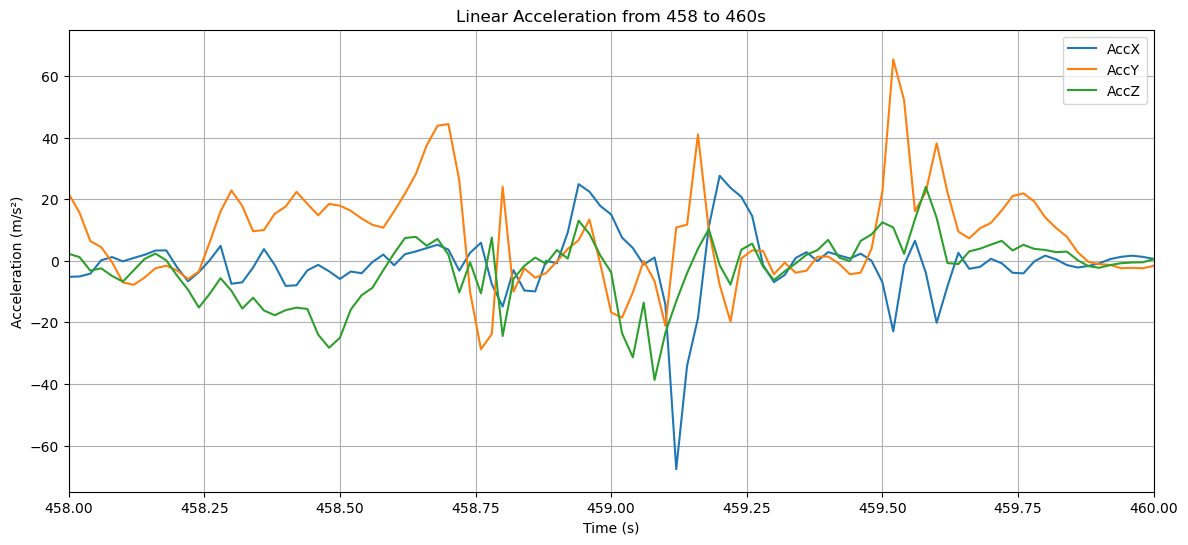

In [17]:
#Plot from 0.2s to 0.3s
plt.figure(figsize=(14, 6))
plt.plot(df['time'], df['AccX'], label='AccX')
plt.plot(df['time'], df['AccY'], label='AccY')
plt.plot(df['time'], df['AccZ'], label='AccZ')
plt.xlim(458, 460)  # Adjust x-axis limits to zoom in
plt.ylim(-75, 75)  # Adjust y-axis limits 
plt.title('Linear Acceleration from 458 to 460s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
print(np.isnan(df['AccZ']).sum(), np.isnan(df['AccY']).sum(), np.isnan(df['AccX']).sum())

4 4 4


### Clean

In [19]:
# Drop rows with any NaN in AccX, AccY, or AccZ
df_clean = df.dropna(subset=['AccX', 'AccY', 'AccZ'])

In [20]:
# Now extract the cleaned arrays
acc_x = df_clean['AccX'].values
acc_y = df_clean['AccY'].values
acc_z = df_clean['AccZ'].values

### Find peaks

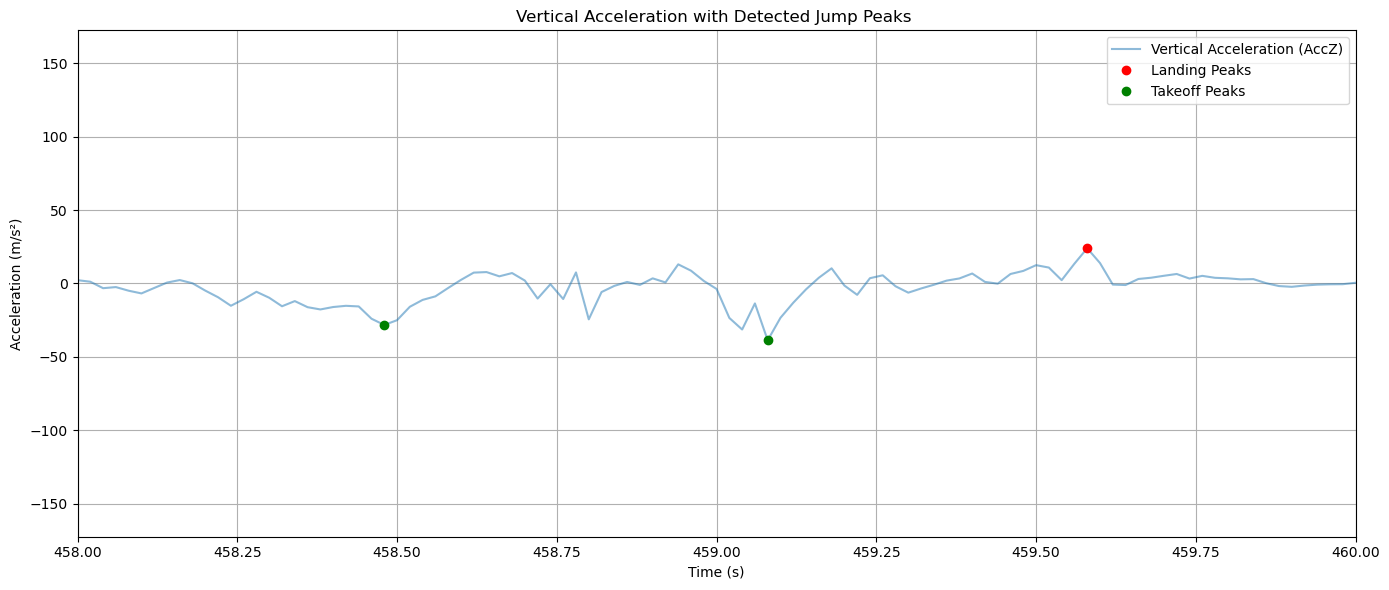

In [21]:
# Detecting peaks for jump events
from scipy.signal import find_peaks 


# Detect peaks (landings: high +ve AccZ, takeoffs: high -ve AccZ)
peaks_positive, _ = find_peaks(acc_z, height=15, distance=20)
peaks_negative, _ = find_peaks(-acc_z, height=15, distance=20)

# Plot data in selected range
start_time = 458
end_time = 460
mask = (df_clean['time'] >= start_time) & (df_clean['time'] <= end_time)

plt.figure(figsize=(14, 6))
plt.plot(df_clean['time'][mask], acc_z[mask], label='Vertical Acceleration (AccZ)', alpha=0.5)
plt.xlim(458, 460)  # Adjust x-axis limits to zoom in
plt.plot(df_clean['time'].iloc[peaks_positive], acc_z[peaks_positive], 'ro', label='Landing Peaks')
plt.plot(df_clean['time'].iloc[peaks_negative], acc_z[peaks_negative], 'go', label='Takeoff Peaks')
plt.title(f"Vertical Acceleration with Detected Jump Peaks ")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Butterworth filter and plot

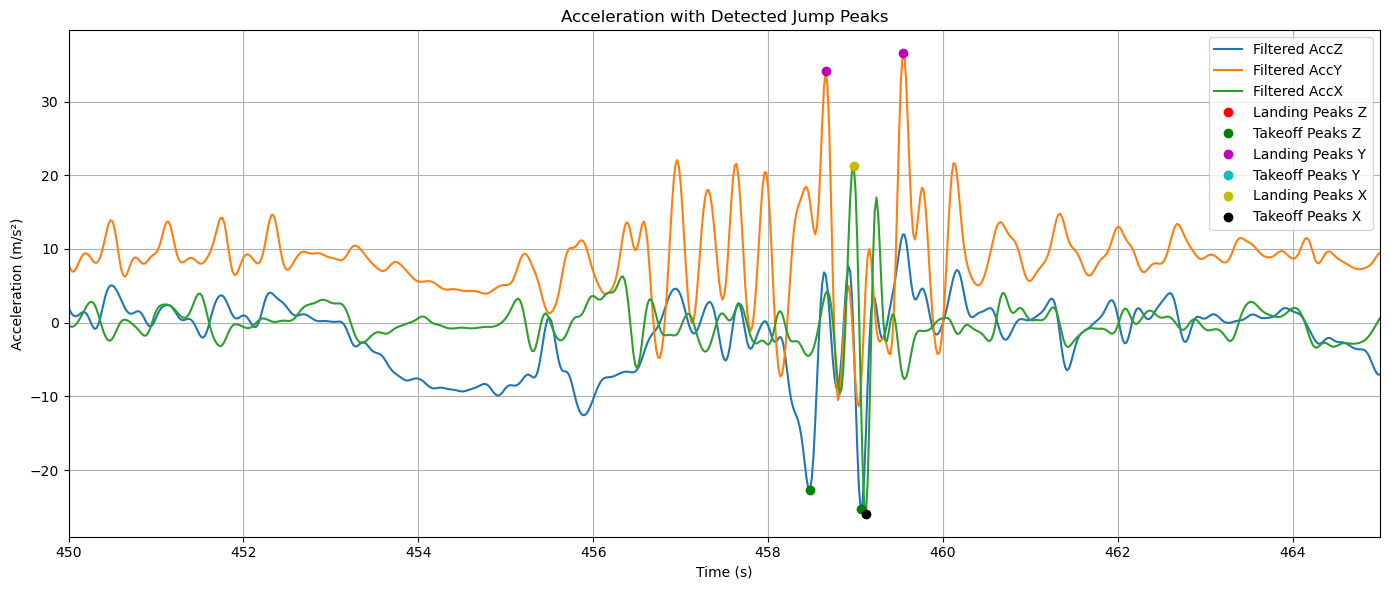

In [22]:
from scipy.signal import butter, filtfilt

# Low-pass filter setup
def butter_lowpass_filter(data, cutoff=5, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_acc_z = butter_lowpass_filter(acc_z, cutoff=5, fs=sample_rate)
filtered_acc_y = butter_lowpass_filter(acc_y, cutoff=5, fs=sample_rate)
filtered_acc_x = butter_lowpass_filter(acc_x, cutoff=5, fs=sample_rate)

# Detect peaks (landings: high +ve AccZ, takeoffs: high -ve AccZ)
peaks_positive_z, _ = find_peaks(filtered_acc_z, height=15, distance=20)
peaks_negative_z, _ = find_peaks(-filtered_acc_z, height=15, distance=20)
peaks_positive_y, _ = find_peaks(filtered_acc_y, height=15, distance=20)
peaks_negative_y, _ = find_peaks(-filtered_acc_y, height=15, distance=20)
peaks_positive_x, _ = find_peaks(filtered_acc_x, height=15, distance=20)
peaks_negative_x, _ = find_peaks(-filtered_acc_x, height=15, distance=20)

# Helper: Return only peaks in visible range
def filter_peaks(peaks, mask):
    return [p for p in peaks if mask.iloc[p]]

# Filter peaks
filtered_peaks_pos_z = filter_peaks(peaks_positive_z, mask)
filtered_peaks_neg_z = filter_peaks(peaks_negative_z, mask)
filtered_peaks_pos_y = filter_peaks(peaks_positive_y, mask)
filtered_peaks_neg_y = filter_peaks(peaks_negative_y, mask)
filtered_peaks_pos_x = filter_peaks(peaks_positive_x, mask)
filtered_peaks_neg_x = filter_peaks(peaks_negative_x, mask)


# Plot data in selected range
start_time = 450
end_time = 465
mask = (df_clean['time'] >= start_time) & (df_clean['time'] <= end_time)

plt.figure(figsize=(14, 6))
plt.plot(df_clean['time'][mask], filtered_acc_z[mask], label='Filtered AccZ')
plt.plot(df_clean['time'][mask], filtered_acc_y[mask], label='Filtered AccY')
plt.plot(df_clean['time'][mask], filtered_acc_x[mask], label='Filtered AccX')
plt.plot(df_clean['time'].iloc[filtered_peaks_pos_z], filtered_acc_z[filtered_peaks_pos_z], 'ro', label='Landing Peaks Z')
plt.plot(df_clean['time'].iloc[filtered_peaks_neg_z], filtered_acc_z[filtered_peaks_neg_z], 'go', label='Takeoff Peaks Z')
plt.plot(df_clean['time'].iloc[filtered_peaks_pos_y], filtered_acc_y[filtered_peaks_pos_y], 'mo', label='Landing Peaks Y')
plt.plot(df_clean['time'].iloc[filtered_peaks_neg_y], filtered_acc_y[filtered_peaks_neg_y], 'co', label='Takeoff Peaks Y')
plt.plot(df_clean['time'].iloc[filtered_peaks_pos_x], filtered_acc_x[filtered_peaks_pos_x], 'yo', label='Landing Peaks X')
plt.plot(df_clean['time'].iloc[filtered_peaks_neg_x], filtered_acc_x[filtered_peaks_neg_x], 'ko', label='Takeoff Peaks X')
plt.xlim(450, 465)  # Adjust x-axis limits to zoom in
plt.title(f"Acceleration with Detected Jump Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Build model for identifying jumps 

In [26]:
jump_windows = []

# Pair takeoff and landing peaks by time (assumes jumps go: takeoff → landing)
for takeoff_idx in peaks_negative_z:
    takeoff_time = df['time'].iloc[takeoff_idx]

    # Find the first landing peak *after* this takeoff
    landing_idx = next((i for i in peaks_positive_z if i > takeoff_idx), None)
    
    if landing_idx:
        landing_time = df['time'].iloc[landing_idx]
        jump_windows.append((takeoff_time, landing_time))




In [27]:
#Check the list
for i, (start, end) in enumerate(jump_windows):
    print(f"Jump {i+1}: from {start:.2f}s to {end:.2f}s (duration: {end-start:.2f}s)")

Jump 1: from 248.30s to 598.44s (duration: 350.14s)
Jump 2: from 423.16s to 598.44s (duration: 175.28s)
Jump 3: from 423.72s to 598.44s (duration: 174.72s)
Jump 4: from 458.48s to 598.44s (duration: 139.96s)
Jump 5: from 459.06s to 598.44s (duration: 139.38s)
Jump 6: from 469.86s to 598.44s (duration: 128.58s)
Jump 7: from 470.42s to 598.44s (duration: 128.02s)
Jump 8: from 495.74s to 598.44s (duration: 102.70s)
Jump 9: from 506.72s to 598.44s (duration: 91.72s)
Jump 10: from 507.30s to 598.44s (duration: 91.14s)
Jump 11: from 546.38s to 598.44s (duration: 52.06s)
Jump 12: from 546.98s to 598.44s (duration: 51.46s)
Jump 13: from 597.94s to 598.44s (duration: 0.50s)


In [28]:
from scipy.stats import skew, kurtosis

# Window settings
window_size = int(sample_rate * 1.0)  # 1 second
stride = int(sample_rate * 0.25)      # 75% overlap

features = []
timestamps = []

for start in range(0, len(df) - window_size, stride):
    end = start + window_size
    window = filtered_acc_z[start:end]

    ts = df['time'].iloc[start]
    
    features.append([
        np.mean(window),
        np.std(window),
        np.max(window),
        np.min(window),
        np.ptp(window),            # Peak-to-peak
        np.argmax(window),         # Index of peak
        np.argmin(window),         # Index of trough
        skew(window),
        kurtosis(window)
    ])
    timestamps.append(ts)




In [29]:
# Create DataFrame
X = pd.DataFrame(features, columns=[
    'mean', 'std', 'max', 'min', 'ptp', 'argmax', 'argmin', 'skew', 'kurtosis'
])


In [30]:
def is_in_jump_window(t, windows):
    for start, end in windows:
        if start <= t <= end:
            return 1
    return 0

y = [is_in_jump_window(t, jump_windows) for t in timestamps]


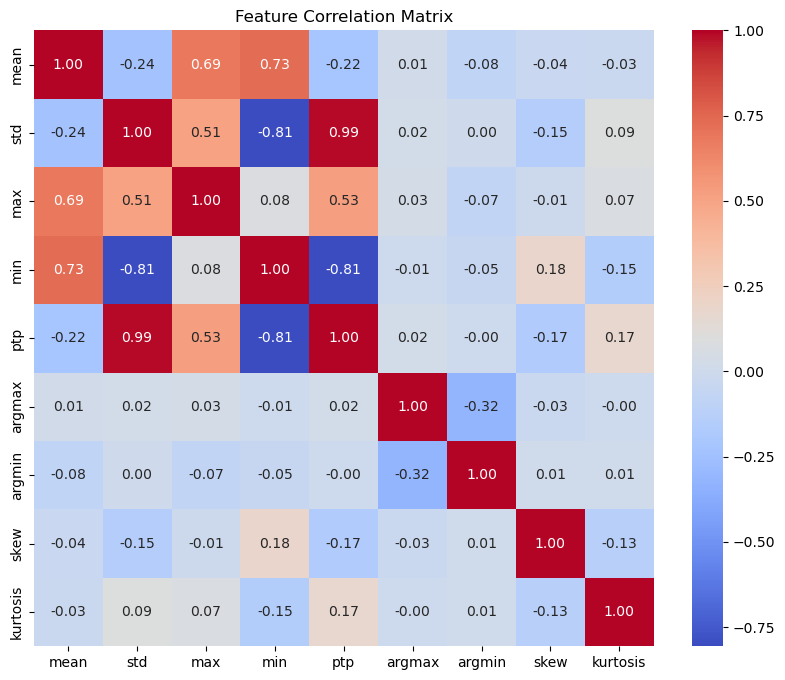

<Figure size 640x480 with 0 Axes>

In [33]:
# Feature correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()
plt.tight_layout()  

In [ ]:
#Evaluate model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 

### Fuse Gyro data and filter 

In [ ]:
import imufusion

# Create a new AHRS filter object
ahrs = imufusion.Ahrs()
ahrs.settings = imufusion.Settings(100)  # Set sample rate to 100 Hz    
ahrs.settings.acceleration_rejection = 0.1  # Adjust as needed
ahrs.settings.gyro_rejection = 0.1  # Adjust as needed
ahrs.settings.magnetic_rejection = 0.1  # Adjust as needed
ahrs.settings.gyro_bias_correction = True

